# Setting things up

In [45]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

BASE_PATH = 'store-sales/'
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Context
In this competition, you will predict sales for the thousands of product families sold at Favorita stores located in Ecuador. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models.

## File Descriptions and Data Field Information
### train.csv
- The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
- store_nbr identifies the store at which the products are sold.
- family identifies the type of product sold.
- sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
- onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

### test.csv
- The test data, having the same features as the training data. You will predict the target sales for the dates in this file.
- The dates in the test data are for the 15 days after the last date in the training data.

### sample_submission.csv
- A sample submission file in the correct format.

### stores.csv
- Store metadata, including city, state, type, and cluster.
- cluster is a grouping of similar stores.

### oil.csv
- Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

### holidays_events.csv
- Holidays and Events, with metadata
- NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
- Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

## Additional Notes
- Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
- A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

# Data cleaning
## Retrieving the data

In [46]:
holiday_events_df = pd.read_csv(BASE_PATH + 'holidays_events.csv', parse_dates=['date'])
stores_df = pd.read_csv(BASE_PATH + 'stores.csv')
transactions_df = pd.read_csv(BASE_PATH + 'transactions.csv', parse_dates=['date'])
train_df = pd.read_csv(BASE_PATH + 'train.csv', parse_dates=['date'])
test_df = pd.read_csv(BASE_PATH + 'test.csv', parse_dates=['date'])
oil_df = pd.read_csv(BASE_PATH + 'oil.csv', parse_dates=['date'])
sample_submission_df = pd.read_csv(BASE_PATH + 'sample_submission.csv')

holiday_events_df = holiday_events_df.set_index('date').to_period("D")
transactions_df = transactions_df.set_index('date').to_period("D")
train_df = train_df.set_index('date').to_period("D")
test_df = test_df.set_index('date').to_period("D")
oil_df = oil_df.set_index("date").to_period("D")

In [47]:
holiday_events_df

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...
2017-12-22,Additional,National,Ecuador,Navidad-3,False
2017-12-23,Additional,National,Ecuador,Navidad-2,False
2017-12-24,Additional,National,Ecuador,Navidad-1,False


In [48]:
stores_df

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


In [49]:
transactions_df

,store_nbr,transactions
date,,
2013-01-01,25,770
2013-01-02,1,2111
2013-01-02,2,2358
2013-01-02,3,3487
2013-01-02,4,1922
...,...,...
2017-08-15,50,2804
2017-08-15,51,1573
2017-08-15,52,2255


In [50]:
train_df

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.000,0
2013-01-01,1,1,BABY CARE,0.000,0
2013-01-01,2,1,BEAUTY,0.000,0
2013-01-01,3,1,BEVERAGES,0.000,0
2013-01-01,4,1,BOOKS,0.000,0
...,...,...,...,...,...
2017-08-15,3000883,9,POULTRY,438.133,0
2017-08-15,3000884,9,PREPARED FOODS,154.553,1
2017-08-15,3000885,9,PRODUCE,2419.729,148


In [51]:
test_df

,id,store_nbr,family,onpromotion
date,,,,
2017-08-16,3000888,1,AUTOMOTIVE,0
2017-08-16,3000889,1,BABY CARE,0
2017-08-16,3000890,1,BEAUTY,2
2017-08-16,3000891,1,BEVERAGES,20
2017-08-16,3000892,1,BOOKS,0
...,...,...,...,...
2017-08-31,3029395,9,POULTRY,1
2017-08-31,3029396,9,PREPARED FOODS,0
2017-08-31,3029397,9,PRODUCE,1


In [52]:
oil_df

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20
...,...
2017-08-25,47.65
2017-08-28,46.40
2017-08-29,46.46


In [53]:
sample_submission_df

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0
...,...,...
28507,3029395,0.0
28508,3029396,0.0
28509,3029397,0.0
28510,3029398,0.0


## Examining the data
### Holiday events

In [54]:
holiday_events_df

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...
2017-12-22,Additional,National,Ecuador,Navidad-3,False
2017-12-23,Additional,National,Ecuador,Navidad-2,False
2017-12-24,Additional,National,Ecuador,Navidad-1,False


In [55]:
holiday_events_df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 350 entries, 2012-03-02 to 2017-12-26
Freq: D
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   type         350 non-null    object
 1   locale       350 non-null    object
 2   locale_name  350 non-null    object
 3   description  350 non-null    object
 4   transferred  350 non-null    bool  
dtypes: bool(1), object(4)
memory usage: 14.0+ KB


<AxesSubplot:>

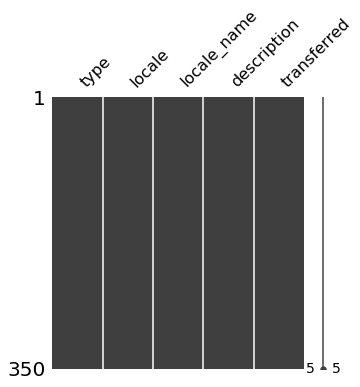

In [56]:
msno.matrix(holiday_events_df, figsize=(5,5))

In [57]:
holiday_events_df['type'].value_counts()

Holiday       221
Event          56
Additional     51
Transfer       12
Work Day        5
Bridge          5
Name: type, dtype: int64

In [58]:
holiday_events_df['locale'].value_counts()

National    174
Local       152
Regional     24
Name: locale, dtype: int64

In [59]:
holiday_events_df['locale_name'].value_counts()

Ecuador                           174
Quito                              13
Ambato                             12
Guaranda                           12
Riobamba                           12
Latacunga                          12
Guayaquil                          11
Ibarra                              7
Cuenca                              7
Santo Domingo de los Tsachilas      6
Loja                                6
Cayambe                             6
Imbabura                            6
Esmeraldas                          6
Quevedo                             6
Santo Domingo                       6
Machala                             6
El Carmen                           6
Puyo                                6
Cotopaxi                            6
Santa Elena                         6
Libertad                            6
Salinas                             6
Manta                               6
Name: locale_name, dtype: int64

### Stores

In [60]:
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [61]:
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


<AxesSubplot:>

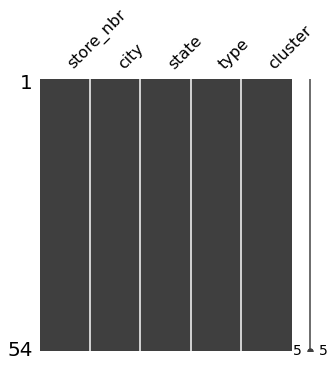

In [62]:
msno.matrix(stores_df, figsize=(5,5))

In [63]:
stores_df['city'].value_counts()

Quito            18
Guayaquil         8
Cuenca            3
Santo Domingo     3
Manta             2
Latacunga         2
Ambato            2
Machala           2
Libertad          1
Daule             1
Esmeraldas        1
Ibarra            1
Babahoyo          1
Playas            1
Quevedo           1
El Carmen         1
Puyo              1
Riobamba          1
Cayambe           1
Guaranda          1
Salinas           1
Loja              1
Name: city, dtype: int64

In [64]:
stores_df['type'].value_counts()

D    18
C    15
A     9
B     8
E     4
Name: type, dtype: int64

### Transactions

In [65]:
transactions_df

,store_nbr,transactions
date,,
2013-01-01,25,770
2013-01-02,1,2111
2013-01-02,2,2358
2013-01-02,3,3487
2013-01-02,4,1922
...,...,...
2017-08-15,50,2804
2017-08-15,51,1573
2017-08-15,52,2255


In [66]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 83488 entries, 2013-01-01 to 2017-08-15
Freq: D
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   store_nbr     83488 non-null  int64
 1   transactions  83488 non-null  int64
dtypes: int64(2)
memory usage: 1.9 MB


<AxesSubplot:>

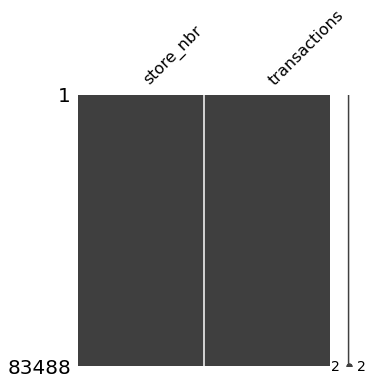

In [67]:
msno.matrix(transactions_df, figsize=(5,5))

### Train/Test

In [68]:
train_df

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.000,0
2013-01-01,1,1,BABY CARE,0.000,0
2013-01-01,2,1,BEAUTY,0.000,0
2013-01-01,3,1,BEVERAGES,0.000,0
2013-01-01,4,1,BOOKS,0.000,0
...,...,...,...,...,...
2017-08-15,3000883,9,POULTRY,438.133,0
2017-08-15,3000884,9,PREPARED FOODS,154.553,1
2017-08-15,3000885,9,PRODUCE,2419.729,148


Considering how 'family' is meant to be about the product type, I do not like this name. I will rename it instead.

In [69]:
train_df.rename(columns = {'family': 'product_family'}, inplace=True)
test_df.rename(columns = {'family': 'product_family'}, inplace=True)
train_df

,id,store_nbr,product_family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.000,0
2013-01-01,1,1,BABY CARE,0.000,0
2013-01-01,2,1,BEAUTY,0.000,0
2013-01-01,3,1,BEVERAGES,0.000,0
2013-01-01,4,1,BOOKS,0.000,0
...,...,...,...,...,...
2017-08-15,3000883,9,POULTRY,438.133,0
2017-08-15,3000884,9,PREPARED FOODS,154.553,1
2017-08-15,3000885,9,PRODUCE,2419.729,148


In [70]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Freq: D
Data columns (total 5 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              int64  
 1   store_nbr       int64  
 2   product_family  object 
 3   sales           float64
 4   onpromotion     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [71]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 28512 entries, 2017-08-16 to 2017-08-31
Freq: D
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              28512 non-null  int64 
 1   store_nbr       28512 non-null  int64 
 2   product_family  28512 non-null  object
 3   onpromotion     28512 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.1+ MB


/home/nimenides/.local/lib/python3.8/site-packages/missingno/missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


<AxesSubplot:>

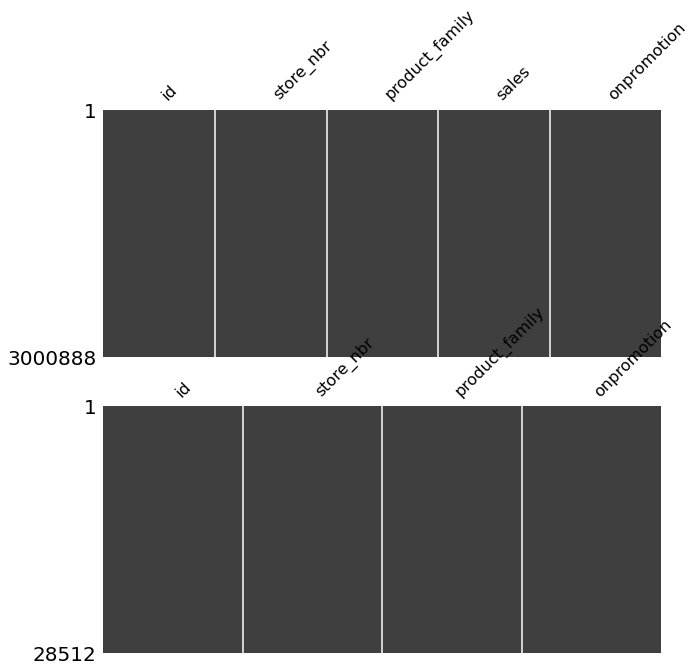

In [72]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,10))

msno.matrix(train_df, ax=ax1)
msno.matrix(test_df,  ax=ax2)

### Oil

In [73]:
oil_df

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20
...,...
2017-08-25,47.65
2017-08-28,46.40
2017-08-29,46.46


This data will be important as some countries like Ecuador are oil-dependent and this should be taken into account.

In [74]:
oil_df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1218 entries, 2013-01-01 to 2017-08-31
Freq: D
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dcoilwtico  1175 non-null   float64
dtypes: float64(1)
memory usage: 19.0 KB


dcoilwtico    43
dtype: int64


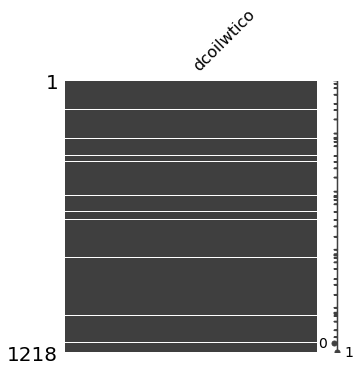

In [75]:
msno.matrix(oil_df, figsize=(5,5))
print(oil_df.isnull().sum())

It appears that there's missing data in the "dcoilwtico" column in a irregular pattern. Since there aren't many missing values at all, I think it is safe to remove the rows with missing values.

In [76]:
oil_df.dropna(inplace=True)

# Exploratory Data Analysis

In [77]:
# https://www.kaggle.com/code/ryanholbrook/seasonality
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

## Holiday events

In [78]:
holiday_events_df

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...
2017-12-22,Additional,National,Ecuador,Navidad-3,False
2017-12-23,Additional,National,Ecuador,Navidad-2,False
2017-12-24,Additional,National,Ecuador,Navidad-1,False


<AxesSubplot:xlabel='locale', ylabel='Count'>

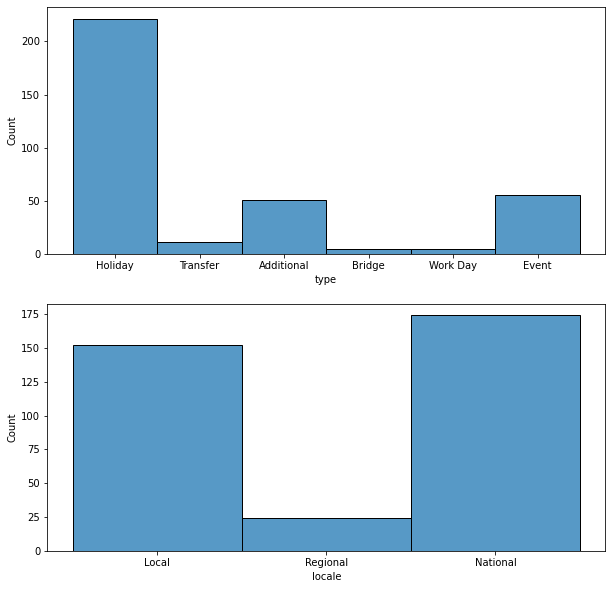

In [79]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,10))

sns.histplot(holiday_events_df['type'], ax=ax1)
sns.histplot(holiday_events_df['locale'], ax=ax2)

It appears that most "holiday events" are holidays with "Additional" just being special days (e.g. Christmas) and "Bridge" days being extra days added to a holiday. "Work Day" seems to make up for the "Bridge" days where it occurs on unconventional days (e.g. weekends). "National" seems to be equivalent to "Ecuador" as this data is based from a Ecuadorian retailer.

<AxesSubplot:xlabel='transferred', ylabel='count'>

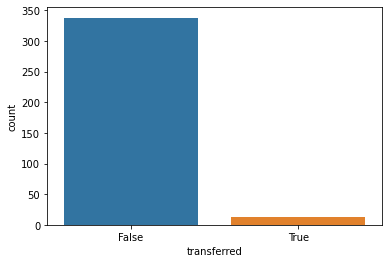

In [80]:
sns.countplot(x=holiday_events_df['transferred'])

Unsurprisingly, many of the events haven't been transferred. We may want to take transfers into account if we wish to improve our forecasting model.

## Transactions

In [81]:
transactions_df.head()

,store_nbr,transactions
date,,
2013-01-01,25,770
2013-01-02,1,2111
2013-01-02,2,2358
2013-01-02,3,3487
2013-01-02,4,1922


In [82]:
transactions_df.index.values

array([Period('2013-01-01', 'D'), Period('2013-01-02', 'D'),
       Period('2013-01-02', 'D'), ..., Period('2017-08-15', 'D'),
       Period('2017-08-15', 'D'), Period('2017-08-15', 'D')], dtype=object)

<AxesSubplot:xlabel='date', ylabel='transactions'>

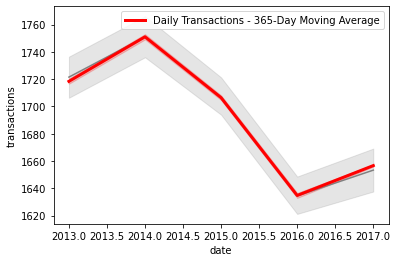

In [83]:
transactions_df['moving_avg'] = transactions_df['transactions'].rolling(
    window=730,
    center=True,
    min_periods=315,
).mean()

sns.lineplot(x=transactions_df.index.year, y='transactions', data=transactions_df, color="0.5")
sns.lineplot(x=transactions_df.index.year, y='moving_avg', data=transactions_df,
             linewidth=3, label="Daily Transactions - 365-Day Moving Average",
             color="red")

From a glance, we can see that there are peaks on a annual basis starting from 2014 of transactions moving past 2000 transactions within a day. We should account for this seasonality in our forecasting model.

/opt/anaconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


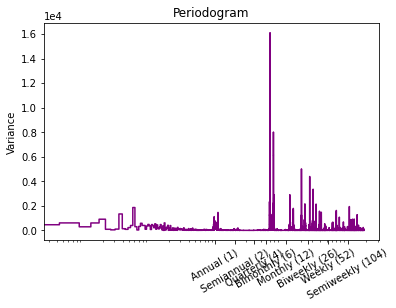

In [84]:
from scipy.signal import periodogram

fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
frequencies, spectrum = periodogram(
    transactions_df['transactions'],
    fs=fs,
    detrend='linear',
    window='boxcar',
    scaling='spectrum'
)

_, ax = plt.subplots()
ax.step(frequencies, spectrum, color="purple")
ax.set_xscale("log")
ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
ax.set_xticklabels(
    [
        "Annual (1)",
        "Semiannual (2)",
        "Quarterly (4)",
        "Bimonthly (6)",
        "Monthly (12)",
        "Biweekly (26)",
        "Weekly (52)",
        "Semiweekly (104)",
    ],
    rotation=30,
)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
ax.set_ylabel("Variance")
ax.set_title("Periodogram")
plt.show()

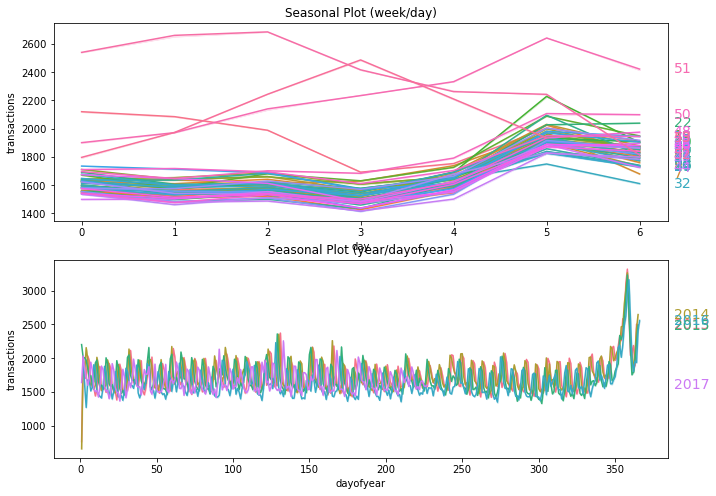

In [108]:
X = transactions_df.copy()

X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 8))
seasonal_plot(X, y="transactions", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="transactions", period="year", freq="dayofyear", ax=ax1);

In [ ]:
def seasonal_line_plot(x, y, period, freq, title, ax):
    ax = sns.lineplot(
        x=x,
        y=y,
        hue=hue,
        data=X,
        ci=False,
        ax=ax0,
        legend=False,
    )
    ax.set_title(title)
    return ax

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 8))
    
seasonal_line_plot("day", y, "week", X, title="Seasonal Plot (Weekly)", ax=ax0)
seasonal_line_plot("dayofyear", y, "year", X, title="Seasonal Plot (Yearly)", ax=ax1)

In [87]:
transactions_df

,store_nbr,transactions,moving_avg
date,,,
2013-01-01,25,770,1776.419178
2013-01-02,1,2111,1776.418033
2013-01-02,2,2358,1777.648501
2013-01-02,3,3487,1777.671196
2013-01-02,4,1922,1774.831978
...,...,...,...
2017-08-15,50,2804,1596.605405
2017-08-15,51,1573,1595.504065
2017-08-15,52,2255,1597.548913


In [88]:
transactions_df['Lag_1'] = transactions_df['transactions'].shift(1)
transactions_df.head()

,store_nbr,transactions,moving_avg,Lag_1
date,,,,
2013-01-01,25,770,1776.419178,NaN
2013-01-02,1,2111,1776.418033,770.0
2013-01-02,2,2358,1777.648501,2111.0
2013-01-02,3,3487,1777.671196,2358.0
2013-01-02,4,1922,1774.831978,3487.0


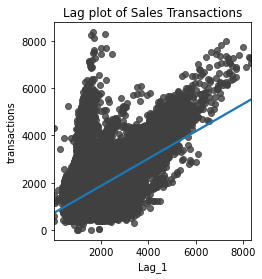

In [89]:
fig, ax = plt.subplots()

ax = sns.regplot(x='Lag_1', y='transactions', data=transactions_df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title("Lag plot of Sales Transactions")
ax.set_aspect("equal")

From this, we know that there is a serial dependence, suggesting that there is a relationship between current and previous transactions.

## Oil

In [90]:
oil_df.head()

,dcoilwtico
date,
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20
2013-01-08,93.21


Text(0.5, 1.0, 'Daily oil price - 365-Day Moving Average')

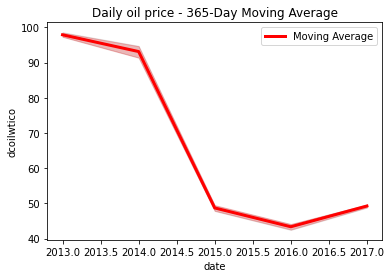

In [91]:
oil_df['moving_avg'] = oil_df['dcoilwtico'].rolling(
    window=31,
    center=True,
    min_periods=15,
).mean()

sns.lineplot(x=oil_df.index.year, y='dcoilwtico', data=oil_df, color="0.5")
sns.lineplot(x=oil_df.index.year, y='moving_avg', data=oil_df,
             linewidth=3, label="Moving Average",
             color="red")
plt.title("Daily oil price - 365-Day Moving Average")

It seems that oil price was steady until mid-2014 when it suddenly decreased until the beginning of 2015. This seems to suggest that oil price fluctates less consistently and that it will need to be taken into account (critical supply chain operations such as delivery rely on oil).

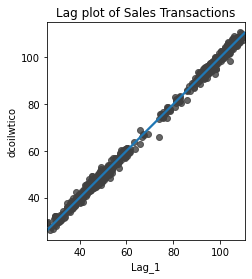

In [92]:
oil_df['Lag_1'] = oil_df['dcoilwtico'].shift(1)

fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='dcoilwtico', data=oil_df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title("Lag plot of Sales Transactions")
ax.set_aspect("equal")

## Stores

In [93]:
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


<AxesSubplot:>

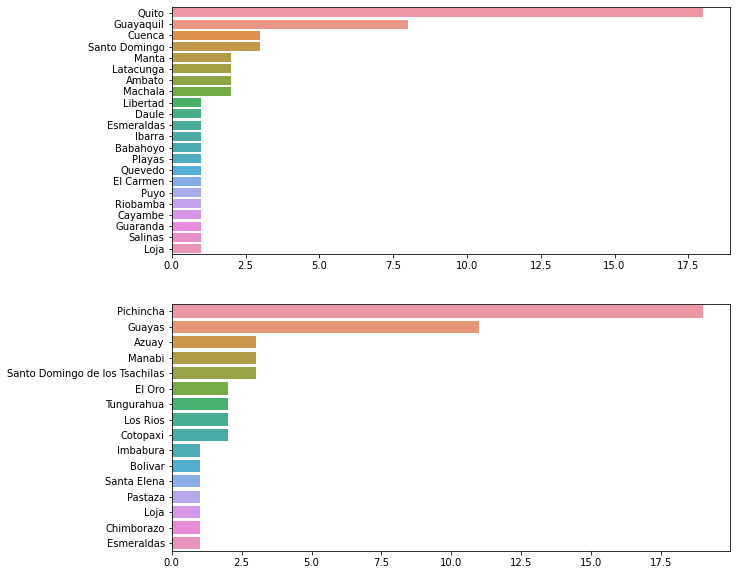

In [94]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,10))

cities_counts = stores_df['city'].value_counts().values
distinct_cities = stores_df['city'].value_counts().index.to_list()

states_counts = stores_df['state'].value_counts().values
distinct_states = stores_df['state'].value_counts().index.to_list()

sns.barplot(x=cities_counts, y=distinct_cities, ax=ax1)
sns.barplot(x=states_counts, y=distinct_states, ax=ax2)

It appears that most data points reside in the cities of Qutio and Guayaquil. Pichincha and Guayas seem to be the most popular states.

<AxesSubplot:>

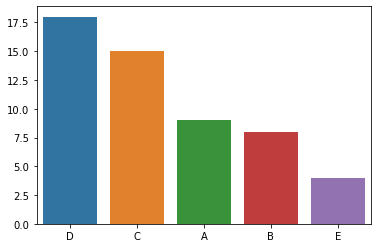

In [95]:
types = stores_df['type'].value_counts().values
distinct_types = stores_df['type'].value_counts().index.to_list()

sns.barplot(x=distinct_types, y=types)

## Train/Test

In [96]:
train_df.head()

,id,store_nbr,product_family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0


<AxesSubplot:xlabel='count', ylabel='product_family'>

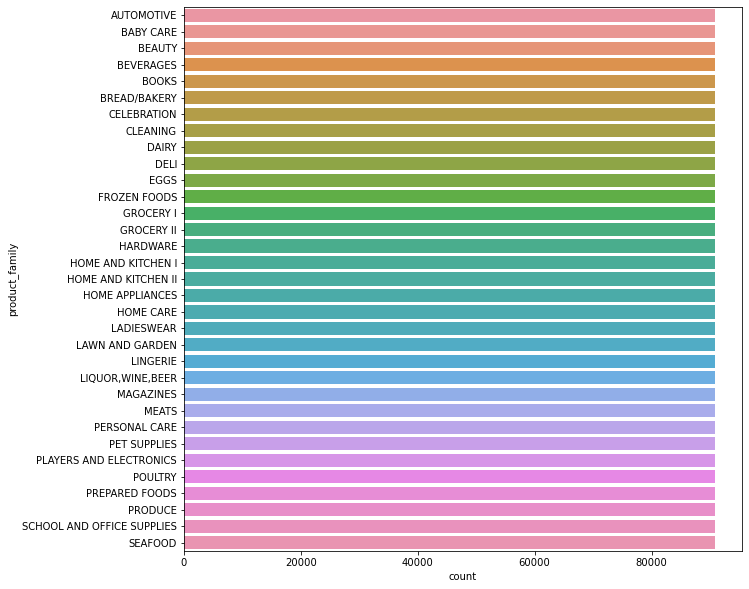

In [97]:
fig, ax = plt.subplots(figsize=(10,10))
sns.countplot(y=train_df['product_family'])

It seems that this dataset has precisely **equal** proportions for different product families. However, we could merge some families together as I cannot see the difference between "HOME AND KITCHEN I" and "HOME AND KITCHEN II" for example.

<AxesSubplot:xlabel='date', ylabel='sales'>

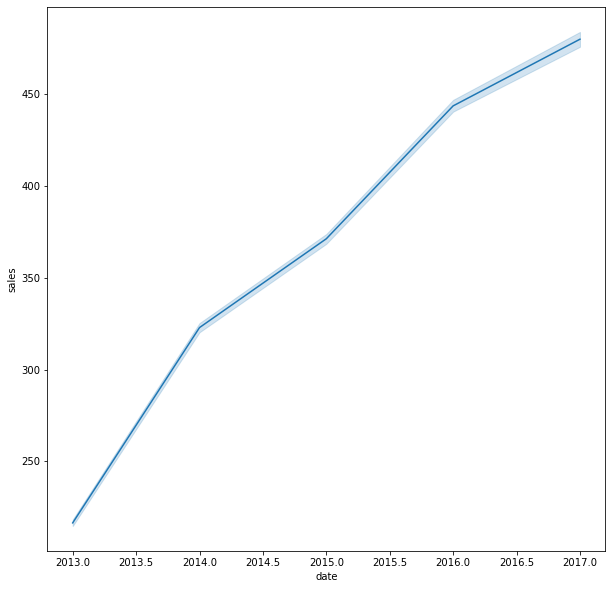

In [98]:
_, _ = plt.subplots(figsize=(10,10))
sns.lineplot(x=train_df.index.year, y='sales', data=train_df)

It seems that sales has increased over the years (but so has variance in sales), however I find the annual dips in sales to be quite strange considering the annual increase in transactions. Why would there be a dip in sales if there's an increase in transactions? An explanation for this dip could be that there's annual discounts which motivate more transactions but they could lead to less sales (I feel this is unlikely to be the case).

Sales appears to fluctate significantly between 2014 and 2015 which is when the oil prices decrease significantly (oil price clearly affects sales in a significant way here).

In [99]:
train_df[train_df['sales'] == 0]

,id,store_nbr,product_family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0
...,...,...,...,...,...
2017-08-15,3000839,8,HOME APPLIANCES,0.0,0
2017-08-15,3000853,8,SCHOOL AND OFFICE SUPPLIES,0.0,0
2017-08-15,3000856,9,BABY CARE,0.0,0


In [100]:
sales_above_0_percent = len(train_df[train_df['sales'] == 0]) / len(train_df) * 100
f'{round(sales_above_0_percent, 2)}%'

'31.3%'

Interestingly enough, ~31.3% of stores have 0 sales which I find to be quite strange given the amount of data available. I don't know why this is the case.

<AxesSubplot:xlabel='sales', ylabel='product_family'>

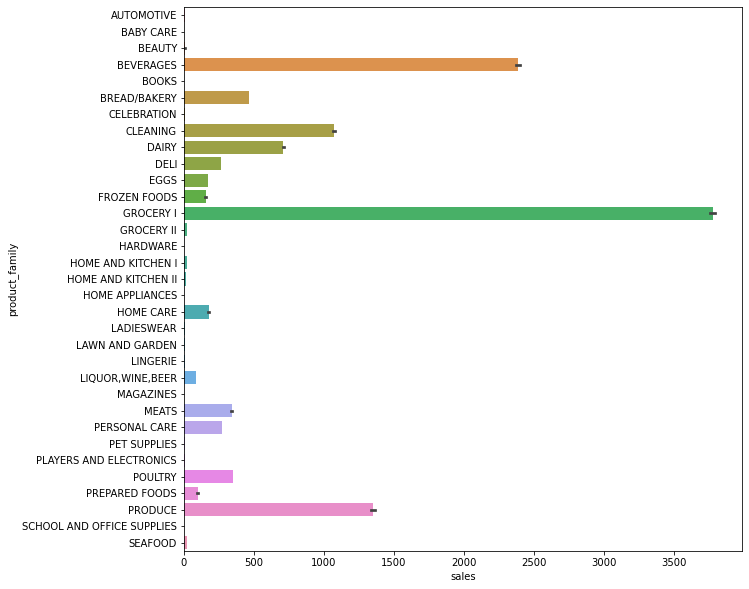

In [101]:
_,_ = plt.subplots(figsize=(10,10))
sns.barplot(y='product_family', x='sales', data=train_df)

Product family is quite clearly a way of predicting sales as some product families are much more popular than others (e.g. groceries will be much more popular than pet supplies).

## Correlation
For analyzing correlation, I'll just merge a bunch of tables together, remove useless attributes from the merged table and create a heatmap for the correlation matrix.

In [102]:
(train_df.shape, transactions_df.shape, oil_df.shape)

((3000888, 5), (83488, 4), (1175, 3))

In [103]:
transactions_oils_df = pd.merge(transactions_df, oil_df, how='inner', on='date')
train_merged_df = pd.merge(transactions_oils_df, train_df, how='inner', on=['date', 'store_nbr'])
test_merged_df = pd.merge(oil_df, test_df, how='inner', on='date')
train_merged_df

,store_nbr,transactions,moving_avg_x,Lag_1_x,dcoilwtico,moving_avg_y,Lag_1_y,id,product_family,sales,onpromotion
date,,,,,,,,,,,
2013-01-02,1,2111,1776.418033,770.0,93.14,94.096250,NaN,1782,AUTOMOTIVE,2.000,0
2013-01-02,1,2111,1776.418033,770.0,93.14,94.096250,NaN,1783,BABY CARE,0.000,0
2013-01-02,1,2111,1776.418033,770.0,93.14,94.096250,NaN,1784,BEAUTY,2.000,0
2013-01-02,1,2111,1776.418033,770.0,93.14,94.096250,NaN,1785,BEVERAGES,1091.000,0
2013-01-02,1,2111,1776.418033,770.0,93.14,94.096250,NaN,1786,BOOKS,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...
2017-08-15,54,802,1596.923497,932.0,47.57,48.220714,47.59,3000751,POULTRY,59.619,0
2017-08-15,54,802,1596.923497,932.0,47.57,48.220714,47.59,3000752,PREPARED FOODS,94.000,0
2017-08-15,54,802,1596.923497,932.0,47.57,48.220714,47.59,3000753,PRODUCE,915.371,76


In [104]:
test_merged_df

,dcoilwtico,moving_avg,Lag_1,id,store_nbr,product_family,onpromotion
date,,,,,,,
2017-08-16,46.80,48.237407,47.57,3000888,1,AUTOMOTIVE,0
2017-08-16,46.80,48.237407,47.57,3000889,1,BABY CARE,0
2017-08-16,46.80,48.237407,47.57,3000890,1,BEAUTY,2
2017-08-16,46.80,48.237407,47.57,3000891,1,BEVERAGES,20
2017-08-16,46.80,48.237407,47.57,3000892,1,BOOKS,0
...,...,...,...,...,...,...,...
2017-08-31,47.26,47.464375,45.96,3029395,9,POULTRY,1
2017-08-31,47.26,47.464375,45.96,3029396,9,PREPARED FOODS,0
2017-08-31,47.26,47.464375,45.96,3029397,9,PRODUCE,1


<AxesSubplot:>

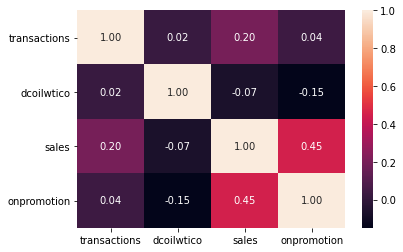

In [105]:
trimmed_train_merged_df = train_merged_df[['transactions', 'dcoilwtico', 'sales', 'onpromotion']]
sns.heatmap(trimmed_train_merged_df.corr(), annot=True, fmt='.2f')

It should come without a surprise that promotions heavily affect sales. Oddly enough, oil price doesn't seem to have much of an effect on sales (at least according to correlation). I still think oil price is quite relevant judging from the earlier analysis we have done. It could be that the oil price is much more relevant during certain time periods for predicting sales.

# Model building

In [106]:
from sklearn.linear_model import LinearRegression

selected_features = ['onpromotion']
X = train_merged_df[selected_features]
y = train_merged_df['sales']
X_test = test_merged_df[selected_features]

lr_reg = LinearRegression()
lr_reg.fit(X, y)
y_pred = lr_reg.predict(X_test)

# Evaluation

In [107]:
from sklearn.metrics import mean_squared_log_error

f'Score: {round(np.sqrt(mean_squared_log_error(X, y)), 2)}%'

'Score: 3.53%'